In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import BSpline, make_interp_spline, interp1d
import seaborn as sns
from matplotlib.patches import Rectangle


In [86]:
medium_font = 10
plt.rc('axes', labelsize=medium_font)#, labelweight = 'bold')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['contour.negative_linestyle'] = 'solid' # contours default to dashed lines when negative; this overrides
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['axes.xmargin'] = 1
plt.rcParams["mathtext.default"] = 'regular' # make any mathtext use same font as normal
plt.rcParams['lines.solid_capstyle'] = 'round'
plt.rcParams['xtick.labelsize'] = 16

sns.set_palette("colorblind")
pal = sns.color_palette()


In [87]:
df = pd.read_csv('all_data_cleaned.csv')
#df_reps = pd.read_csv('/Users/noaha/Documents/MIT/mass_spec/blimp/proj/iowa/results/analyses_iowa.csv')
df_reps = pd.read_csv('all_data_cleaned_reps.csv')
df_ptcount = pd.read_excel('/Users/noaha/Documents/MIT/iowa_miss/ts_stitches/MissData/BW Thin Section Point Counting.xlsx')

In [88]:
frac = 0.4 # set for LOWESS; fraction of data used for estimates.
# Chen 2021 uses 0.2 FWIW

In [89]:

def make_strat_plots(core, df, df_reps):
    
    if core == 'BW':
        n_subplots = 7
    else:
        n_subplots = 5
   
    df = df[df['Location'] == core]
    df_reps = df_reps[df_reps['Location'] == core]
    
    df = df.sort_values('Strat_height_C22-4')
    df_reps = df_reps.sort_values('Strat_height_C22-4')

    fig, axes = plt.subplots(1, n_subplots, sharey = True, figsize = (6, 6), layout="compressed")
    ms = 30
    
    x_reps = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['Strat_height_C22-4']
    y_reps = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['T_MIT']

    T_lowess = lowess(y_reps, x_reps, frac = frac)

    x_reps = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['Strat_height_C22-4']
    y_reps = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['d18Ow_VSMOW']

    d18Ow_lowess = lowess(y_reps, x_reps, frac = frac)
    
    x = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['Strat_height_C22-4']
    y = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['d13C_VPDB']

    d13_lowess = lowess(y, x, frac = frac)
    
    x = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['Strat_height_C22-4']
    y = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['d18O_VPDB_mineral']

    d18_lowess = lowess(y, x, frac = frac)
    
    for ind, _row in df.iterrows():
                
        if _row.Category == 'Dolomite':
            marker = 's'
            color = 'white'
        elif _row.Category == 'Cement':
            marker = '^'
            color = 'white'
        elif _row.Category == 'Vein':
            color = 'white'
            marker = 'v'
        elif _row.Category == 'Fossil':
            color = pal[4]
            marker = 'D'
        else:
            marker = 'o'
            color = 'black' # set to black for now -- can get fancy later
        
        # d13C
        axes[0].scatter(x = _row['d13C_VPDB'],
            y = _row['Strat_height_C22-4'],
            c = color,
            marker=marker, edgecolors='k', s = ms, zorder = 3) 
        
        # D47 T
        axes[1].errorbar(x = _row['T_MIT'],
            y = _row['Strat_height_C22-4'],
            xerr = _row['T_MIT_95CL_upper'],
            c = color,
            ecolor = 'gray',
            marker=marker, mec='k', ms = ms/5, zorder = 3)
        
        # mineral d18O
        axes[2].scatter(x = _row['d18O_VPDB_mineral'],
                    y = _row['Strat_height_C22-4'],
                    c = color,
                    marker= marker, edgecolors = 'k', s = ms, zorder = 3)
       
        # water d18O  
        axes[3].errorbar(x = _row['d18Ow_VSMOW'],
            y = _row['Strat_height_C22-4'],
            xerr = _row['d18Ow_VSMOW_lower'],
            c = color, ecolor = 'gray', elinewidth=1, 
            marker=marker, mec = 'k', ms = ms/5, ls = 'none', zorder = 3)
        
        axes[4].scatter(_row['Mn'], _row['Strat_height_C22-4'],
                        color = color, s = ms, marker = marker,
                       edgecolor = 'black', zorder = 3)


    # PLOT REPS as little gray circles
#     axes[1].scatter(x = df_reps[df_reps['Mineralogy'] == 'Calcite']['T_MIT'],
#             y = df_reps[df_reps['Mineralogy'] == 'Calcite']['Strat_height_C22-4'],
#             c = 'gray',
#             marker='o',edgecolor='k', s = ms/1.8, zorder = 0, alpha = 0.5)
    
    
    
    axes[0].set_ylabel('Depth (ft)')
    axes[0].set_xlim(0, 7)
    axes[0].locator_params(axis='x', nbins=4)
    axes[0].set_xlabel(u'$\delta^{13}C$ (‰, VPDB)')
    axes[0].plot(d13_lowess.T[1], d13_lowess.T[0], color = 'black', zorder = 0)

    
    #axes[1].axvline(30, color = 'black', ls = '--')
    axes[1].set_xlim(0, 90)
    axes[1].locator_params(axis='x', nbins=4)
    axes[1].set_xlabel(u'T$\Delta_{47} (\degree$C)')
    axes[1].plot(T_lowess.T[1], T_lowess.T[0], color = 'black', zorder = 0) # LOWESS weighted for number of reps

    
    axes[2].set_xlim(-7, 0)
    axes[2].locator_params(axis='x', nbins=4)
    axes[2].set_xlabel(u'$\delta^{18}O$ (‰, VPDB)')  
    axes[2].plot(d18_lowess.T[1], d18_lowess.T[0], color = 'black', zorder = 0)
    
    
    axes[3].set_xlim(-7, 7)
    axes[3].set_xlabel(u'$\delta^{18}O_w$ \n (‰, VSMOW)')
    axes[3].axvline(-1.4, color = 'black', ls = '--')
    axes[3].locator_params(axis='x', nbins=4)
    axes[3].plot(d18Ow_lowess.T[1], d18Ow_lowess.T[0], color = 'black')

    axes[4].set_xlabel(u'Mn (ppm)')
    axes[4].locator_params(axis='x', nbins=4)
    
    if core == 'BW':
        axes[4].set_xlim(0, 20)    
    else:
        axes[4].set_xlim(0, 60)
    
    if core == 'BW':
    
        axes[5].set_xlim(0, 1)
        axes[5].scatter(np.zeros(len(df['Strat_height_C22-4'])) - 1, df['Strat_height_C22-4'])
        n = 5 # how many sets of boxes we want

        # ADD INFO FROM THIN SECTIONS: FABRIC PRES + BURIAL CEMENTS
        dol_x = 0
        mn_x = 1/n
        karst_x = 2/n
        stylo_x = 3/n
        fab_dest_x = 4/n
        width = 1/n

        axes[5].add_patch(Rectangle((dol_x, 279.4), width, 23, color = 'black'))
        axes[5].add_patch(Rectangle((dol_x, 160), width, 8, color = 'black'))

        axes[5].add_patch(Rectangle((karst_x, axes[0].get_ylim()[0]), width, 24.8, color = 'black')) # 179.4 to ~top

        # Where Mn is > average Mn for section
        axes[5].add_patch(Rectangle((mn_x, 162), width, 4, color = 'black'))
        axes[5].add_patch(Rectangle((mn_x, 194), width, 8, color = 'black'))
        axes[5].add_patch(Rectangle((mn_x, 202), width, 4, color = 'black'))
        axes[5].add_patch(Rectangle((mn_x, 286), width, 12, color = 'black'))
        axes[5].add_patch(Rectangle((mn_x, 310), width, 4, color = 'black'))

        # fabric destruction from thin sections
        fab_dest = [301.4, 273.5, 276.2, 279.0, 199.9, 169.2]

        fab_destr_thickness = 0.2

        for i in fab_dest:        
            axes[5].add_patch(Rectangle((fab_dest_x, i), width, fab_destr_thickness, color = 'black'))

        # NB gets tough starting at box 163.4-173.0
        stylos = [309.4, 299, 298.6, 279.1, 278.7, 277.4, 277, 275.3, 276.3, 272.8, 268.2, 265, 262.4, 257.8, 255.8, 253.2, 252.8,
                 251, 250.5, 250.3, 250.1, 249.1, 248.7, 247.6, 245.8, 244.3, 243.7, 243, 242.8, 241.4, 241.2,
                  239.8, 239.7, 239.6, 239.5, 238.8, 239, 237.3, 237, 238.3, 236.9, 236.7, 236.5, 236.3, 236.2, 
                  236.1 ,235.5, 234.7, 234.6, 234.3, 234.2, 233.7, 233.6, 233.3, 232.8, 232.2, 231.5, 230.2 , 229.9,
                 229.5, 229, 228.3, 228, 227.5, 227, 225.5, 225, 224.7, 224.3, 222.8, 221.9, 220.3, 219.5, 218.9,
                 217.4, 215.7, 213.7, 212.7, 212.5, 212, 210.4, 209.4, 207.5, 207, 203.6, 203.2, 202.1, 201.6, 200.3, 200,
                 192.6, 190.9, 191.2, 189.7, 188, 187.3, 186.2, 186, 185.5, 185.3, 184.9, 184.1, 184.5, 183.3, 183.1, 182.8,
                 182, 181.6, 180.2, 179.2, 178.8, 177.6, 177.2, 176.8, 176, 176.6, 174.6, 174, 173.5, 170.6, 169.4,
                 169, 168.7, 168, 167.2, 166.5, 166.3, 165.7, 164.2, 163.6] 
        stylo_thickness = 0.000125
        for stylo in stylos:
            axes[5].add_patch(Rectangle((stylo_x, stylo), width, stylo_thickness, color = 'black'))

        axes[5].set_xticks([0.2, 0.4, 0.6, 0.8, 1], labels = ['dol', 'mn', 'karst', 'stylo', 'fabric'], rotation = 75)

        axes[5].grid(visible=True, which='major', color='black', zorder = 0, alpha = 1, axis = 'x')


     

        axes[6].plot((df_ptcount.Cement/df_ptcount.Total)*100, df_ptcount.Depth, color = 'black')
        axes[6].set_xlim(0, 50)
        axes[6].set_xlabel('% Cement')
    
    
    plt.gca().invert_yaxis()
#     for i in range(5):
#         axes[i].grid(visible=True, which='major', color='gray', linestyle='--', zorder = 0, alpha = 0.4)
#         #axes[i].grid(visible=True, which='minor', color='gray', linestyle='--', zorder = 0, alpha = 0.2)


    
    if core == 'BW':
        plt.ylim(315, 160)
        #plt.tight_layout(w_pad = 0.0)
    #print(axes[0].get_ylim()[1])
    
    
    #markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    #ax.legend(bbox_to_anchor=(1.1, 1.05))
    #plt.legend(markers, color_map.keys(), numpoints=1, bbox_to_anchor=(1.1, 1.05))
    #fig.savefig(f'/Users/noaha/Documents/MIT/iowa_miss/latest_plots/facies_paper/{core}_strat_full_new.pdf', dpi = 300)

In [90]:

def make_strat_plots(core, df, df_reps):
    
    if core == 'BW':
        n_subplots = 2
    else:
        n_subplots = 2
   
    df = df[df['Location'] == core]
    df_reps = df_reps[df_reps['Location'] == core]
    
    df = df.sort_values('Strat_height_C22-4')
    df_reps = df_reps.sort_values('Strat_height_C22-4')

    fig, axes = plt.subplots(1, n_subplots, sharey = True, figsize = (6, 6), layout="compressed")
    ms = 40
    
    x_reps = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['Strat_height_C22-4']
    y_reps = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['T_MIT']

    T_lowess = lowess(y_reps, x_reps, frac = frac)

    x_reps = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['Strat_height_C22-4']
    y_reps = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['d18Ow_VSMOW']

    d18Ow_lowess = lowess(y_reps, x_reps, frac = frac)
    
    x = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['Strat_height_C22-4']
    y = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['d13C_VPDB']

    d13_lowess = lowess(y, x, frac = frac)
    
    x = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['Strat_height_C22-4']
    y = df_reps[(df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Cement') & (df_reps['Category'] != 'Vein')]['d18O_VPDB_mineral']

    d18_lowess = lowess(y, x, frac = frac)
    
    for ind, _row in df.iterrows():
                
        if _row.Category == 'Dolomite':
            marker = 's'
            color = 'white'
        elif _row.Category == 'Cement':
            marker = '^'
            color = 'white'
        elif _row.Category == 'Vein':
            color = 'white'
            marker = 'v'
        elif _row.Category == 'Fossil':
            color = pal[4]
            marker = 'D'
        else:
            marker = 'o'
            color = 'black' # set to black for now -- can get fancy later
        
        # d13C
        axes[0].scatter(x = _row['d13C_VPDB'],
            y = _row['Strat_height_C22-4'],
            c = color,
            marker=marker, edgecolors='k', s = ms, zorder = 3) 
        
 
        
        # mineral d18O
        axes[1].scatter(x = _row['d18O_VPDB_mineral'],
                    y = _row['Strat_height_C22-4'],
                    c = color,
                    marker= marker, edgecolors = 'k', s = ms, zorder = 3)
       
        # # water d18O  
#         axes[1].errorbar(x = _row['d18Ow_VSMOW'],
#             y = _row['Strat_height_C22-4'],
#             xerr = _row['d18Ow_VSMOW_lower'],
#             c = color, ecolor = 'gray', elinewidth=1, 
#             marker=marker, mec = 'k', ms = ms/5, ls = 'none', zorder = 3)
        


    # PLOT REPS as little gray circles

    
    

    axes[0].set_xlim(0, 7)
    axes[0].locator_params(axis='x', nbins=4)
    #axes[0].set_xlabel(u'$\delta^{13}C$ (‰, VPDB)')
    axes[0].plot(d13_lowess.T[1], d13_lowess.T[0], color = 'black', zorder = 0, lw = 2)

    
    axes[1].set_xlim(-7, 1)
    #axes[1].set_xlabel(u'$\delta^{18}O$ \n (‰, VPDB)')
    #axes[1].axvline(-1.4, color = 'black', ls = '--')
    axes[1].locator_params(axis='x', nbins=4)
    axes[1].plot(d18_lowess.T[1], d18_lowess.T[0], color = 'black', lw = 2)


    
    
    plt.gca().invert_yaxis()
#     for i in range(5):
#         axes[i].grid(visible=True, which='major', color='gray', linestyle='--', zorder = 0, alpha = 0.4)
#         #axes[i].grid(visible=True, which='minor', color='gray', linestyle='--', zorder = 0, alpha = 0.2)


    
    if core == 'BW':
        plt.ylim(315, 170)
        #plt.tight_layout(w_pad = 0.0)
    #print(axes[0].get_ylim()[1])
    
    
    #markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_map.values()]
    #ax.legend(bbox_to_anchor=(1.1, 1.05))
    #plt.legend(markers, color_map.keys(), numpoints=1, bbox_to_anchor=(1.1, 1.05))
    fig.savefig(f'/Users/noaha/Documents/MIT/iowa_miss/latest_plots/facies_paper/{core}_13_18_only.pdf', dpi = 300)#

/var/folders/mb/3rdb69tx38zf1tpnnsprfy0h0000gn/T/ipykernel_44735/4257536899.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[0].scatter(x = _row['d13C_VPDB'],
/var/folders/mb/3rdb69tx38zf1tpnnsprfy0h0000gn/T/ipykernel_44735/4257536899.py:64: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(x = _row['d18O_VPDB_mineral'],
/var/folders/mb/3rdb69tx38zf1tpnnsprfy0h0000gn/T/ipykernel_44735/4257536899.py:56: U

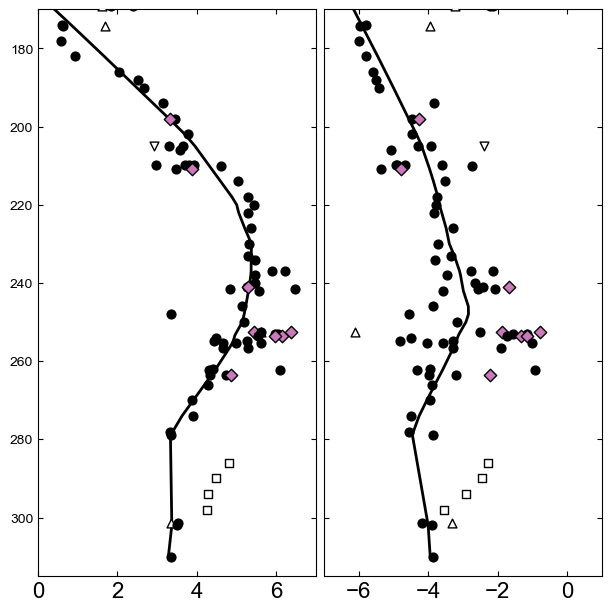

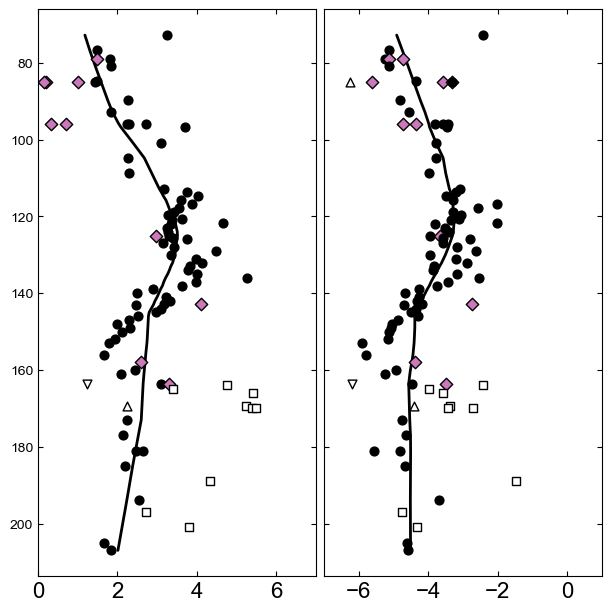

In [91]:
#cores = ['Sully', 'Ames', 'BW', 'Pederson'] # plot all cores

#consider pulling in df_reps as gray circles

cores = ['BW', 'Pederson']
for core in cores:
    make_strat_plots(core, df[df['N'] > 0], df_reps) # place a constraint on N (or anything else) if you want
    

In [92]:
# cores = ['BW']
# for core in cores:
#     make_strat_plots(core, df[(df['Strat_height_C22-4'] > 210) & (df['Strat_height_C22-4'] < 280)], df_reps[(df_reps['Strat_height_C22-4'] > 210) & (df_reps['Strat_height_C22-4'] < 280)]) # place a constraint on N (or anything else) if you want
# cores = ['Pederson']
# for core in cores:
#     make_strat_plots(core, df[(df['Strat_height_C22-4'] > 110) & (df['Strat_height_C22-4'] < 160)], df_reps[(df_reps['Strat_height_C22-4'] > 110) & (df_reps['Strat_height_C22-4'] < 160)]) # place a constraint on N (or anything else) if you want

    

In [8]:
df['R18_h2o'] = ((0.97001 * df['d18Ow_VSMOW'] - 29.99)/1000) + 1 #VPDB, assuming 0,0
df['R18_min'] = df['d18O_VPDB_mineral']/1000+1
df['T (C) CO3 d18O'] = 1/((1000*np.log(df['R18_min']/df['R18_h2o'])+29.1)/(17.5*10**3))-273.15
display(df['T (C) CO3 d18O'])

0      24.780631
1      34.283909
2      75.113469
3      40.842092
4      30.475679
         ...    
178          NaN
179          NaN
180          NaN
181          NaN
182          NaN
Name: T (C) CO3 d18O, Length: 183, dtype: float64

In [9]:
# def lowess_boot(x, y, n, xerr = 0.021):
#     ''' Takes X_data, Y_data, X error, (ideally SD) and number of iterations'''
    
#     bootstrap_slope = []
#     bootstrap_int = []
#     x_err_list = []
#     pred = []
#     boots = []


#     for i in range(len(x)): # Make a normal distribution for each D47
#         D47_dist = np.random.normal(x.iloc[i], xerr, size = 100) # normal dist of xerr
#         D47_high = np.percentile(D47_dist, 97.5)
#         D47_med = np.percentile(D47_dist, 50)
#         D47_low = np.percentile(D47_dist, 2.5)
        
#         pickups = list(range(len(y)))
        
#         # x_err_list will be list of lists
        
#     for _ in range(n): # bootstrap n times
#         D47_boot = []
#         #sample = np.random.choice(pickups, size = int(len(x)))
#         for i in range(len(x)):
#             D47_boot.append(np.random.choice(x_err_list[i])) # for each sample, randomly grab a fmtted T from the normal distribution
#         print(D47_boot)
#     # we WANT n datasets of randomly selected D47 for each height; then we lowess each dataset
#     # list of lists of dict

# lowess_boot(df['D47'], df['Strat_height_C22-4'], 2)



In [10]:
def calc_d18O_T_KON97(d18O_min, d18O_sw):
	'''Calculates T from d18Ow and d18O mineral after Kim and O'Neil (1997) as suggested by Grossman et al. (2022) https://www.danielgaskell.com/d18O/about.html https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2005GC001189
	try deriving a second order polynomial from KON97 and A21 data'''
	return 16.1 - (4.64 * (d18O_min - d18O_sw - 0.27)) + (0.09 * (d18O_min - d18O_sw- 0.27)**2)

def calc_d18O_T_A21(d18O_min, d18O_w):
    R18_w = ((0.97001 * d18O_w - 29.99)/1000) + 1 # VSMOW TO VPDB; calc R
    R18_min = (d18O_min/1000)+1 # calc R
    return 1/((1000*np.log(R18_min/R18_w)+29.1)/(17.5*10**3))-273.15 # T from Anderson et al. (2021)

def calc_MIT_temp(D47_value):
	''' Calculates D47 temp using Eq. 1 calibration from Anderson et al. (2021) 90C'''
	if D47_value > 0.15401: #(prevents complex returns from negative square root)
		return (((0.0391 * 1000000) / (D47_value - 0.154))**0.5) - 273.15
	else:
		return np.nan

In [11]:
df = df.sort_values('Strat_height_C22-4')

df_reps = df_reps.sort_values('Strat_height_C22-4')

In [12]:
# # LOWESS FOR D47 T
# # LOWESS FOR d18O IF T
# # LOWESS FOR d18Ow LOWESS T

# # NB -- need to merge in non-clumped data for reps-level! make new part of all_data_cleaned
# from statsmodels.nonparametric.smoothers_lowess import lowess

# frac = 0.5




# fig, axes = plt.subplots(1, 3, figsize = (9, 4), sharey = True)

# for i in ['BW']:
#     df_active = df_reps[(df_reps['Location'] == i) & (df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Vein') & (df_reps['Category'] != 'Cement')]
#     df_active_sam = df[(df['Location'] == i) & (df['Mineralogy'] == 'Calcite') & (df['Category'] != 'Vein') & (df['Category'] != 'Cement')]
#     d18Ow_lowess = lowess(df_active['d18Ow_VSMOW'], df_active['Strat_height_C22-4'])

#     # Calculate and plot T from d18O_mineral using interpolation of LOWESS-smoothed d18Ow data.
#     df_d18Ow = pd.DataFrame()
#     df_d18Ow['strat'] = d18Ow_lowess.T[0] #
#     df_d18Ow['d18Ow'] = d18Ow_lowess.T[1]
#     f_linear = interp1d(df_d18Ow['strat'], df_d18Ow['d18Ow'], bounds_error=False, kind='linear', fill_value='extrapolate')
#     interp_ht = df_active['Strat_height_C22-4']
#     interp_d18Ow = f_linear(interp_ht)

#     T_d18O_dynamic = []
#     d18O_T_A21_icefree = []
    
#     for i in range(len(df_active)):
#         T_d18O_dynamic.append(calc_d18O_T_A21(df_active['d18O_VPDB_mineral'].iloc[i], interp_d18Ow[i]))
#         d18O_T_A21_icefree.append(calc_d18O_T_A21(df_active['d18O_VPDB_mineral'].iloc[i], -1.1))
 
#     df_active['T_d18O_dynamic'] = T_d18O_dynamic
#     df_active['d18O_T_A21_icefree'] = d18O_T_A21_icefree

#     T_lowess = lowess(df_active['T_MIT'], df_active['Strat_height_C22-4'] , frac = frac)
#     T_lowess_high = lowess(df_active_sam['T_MIT'] + df_active_sam['T_MIT_95CL_upper']/2, df_active_sam['Strat_height_C22-4'] , frac = frac)
#     T_lowess_low = lowess(df_active_sam['T_MIT'] - df_active_sam['T_MIT_95CL_lower']/2, df_active_sam['Strat_height_C22-4'] , frac = frac)
#     d18O_dynamic_lowess = lowess(df_active['T_d18O_dynamic'], df_active['Strat_height_C22-4'], frac = frac)
#     d18O_IF_lowess = lowess(df_active['d18O_T_A21_icefree'], df_active['Strat_height_C22-4'], frac = frac)
#     d13C_lowess = lowess(df_active['d13C_VPDB'], df_active['Strat_height_C22-4'], frac = frac)

#     axes[1].plot(d18O_dynamic_lowess.T[1], d18O_dynamic_lowess.T[0], label = u'$\delta^{18}O$ (var. SW)', color = pal[0])
#     axes[1].plot(d18O_IF_lowess.T[1], d18O_IF_lowess.T[0], label = u'$\delta^{18}O$ (ice-free)', color = pal[1])
#     axes[0].plot(d13C_lowess.T[1], d13C_lowess.T[0], label = 'd13C', color = 'black')
#     axes[1].plot(T_lowess.T[1], T_lowess.T[0], label = u'T$\Delta_{47}$ (1SE)', color = pal[2])
#     #axes[1].plot(T_lowess_high.T[1], T_lowess_high.T[0], label = u'T$\Delta_{47}$', color = pal[2])
#     #axes[1].plot(T_lowess_low.T[1], T_lowess_low.T[0], label = u'T$\Delta_{47}$', color = pal[2])
#     axes[1].fill_betweenx(T_lowess_low.T[0], T_lowess_low.T[1], T_lowess_high.T[1], color = pal[2], alpha = 0.2)
    
#     axes[2].plot(d18Ow_lowess.T[1], d18Ow_lowess.T[0])
    
#     # axes[2].errorbar(x = df_active['d18Ow_VSMOW'],
#     #         y = df_active['Strat_height_C22-4'],
#     #         xerr = df_active['d18Ow_VSMOW_lower'],
#     #         c = 'black', ecolor = 'gray', elinewidth=1, 
#     #         marker='o', mec = 'k', ms = 5, ls = 'none', zorder = 3)
#     print(d18Ow_lowess.T[1].max())
#     axes[2].axvline(-1, color = 'black', ls = '--')
    
# #     axes[axis].scatter(df_active.T_d18O_dynamic, df_active['Strat_height_C22-4'],
# #                 color = pal[0], alpha = 0.2)
# #     axes[axis].scatter(df_active.d18O_T_KON97_icefree, df_active['Strat_height_C22-4'],
# #                 color = pal[1], alpha = 0.2)
#     # axes[axis].scatter(df_active.T_MIT, df_active['Strat_height_C22-4'],
#     #             color = pal[2], alpha = 0.2)
    
    
    


#     axes[0].set_xlim(0, 7)
#     axes[1].set_xlim(25, 45)
#     #axes[1].set_xticks(list(range(25, 45, 1)))
#     axes[2].set_xlim(-4, 0)
 

#     axes[0].grid(visible=True, which='major', color='gray', linestyle='--', zorder = 0, alpha = 0.4)
#     axes[1].grid(visible=True, which='major', color='gray', linestyle='--', zorder = 0, alpha = 0.4)
#     axes[2].grid(visible=True, which='major', color='gray', linestyle='--', zorder = 0, alpha = 0.4)




#     axes[0].scatter(df_active.d13C_VPDB, df_active['Strat_height_C22-4'],
#                     color = 'black', alpha = 0.2)

#     axes[0].scatter(df_active.d13C_VPDB, df_active['Strat_height_C22-4'],
#                     color = 'black', alpha = 0.2)




#     axes[0].legend()
#     axes[1].legend(loc = 'upper left')

#     axes[0].invert_yaxis()
#     axes[1].invert_yaxis()
#     axes[2].invert_yaxis()


#     axes[0].set_xlabel(u'$\delta^{13}C$ (‰, VPDB)')
#     axes[1].set_xlabel(u'T($\degree$C)')
#     axes[2].set_xlabel(u'Fluid $\delta^{18}O$ (‰, VSMOW)')


#     plt.tight_layout()
#     plt.show()
#     #plt.savefig(f'/Users/noaha/Documents/MIT/iowa_miss/latest_plots/three_Ts_and_C.png', dpi = 300)


Maybe use moepy for Lowess to do easy confidence intervals?

https://ayrtonb.github.io/Merit-Order-Effect/ug-08-lowess-quick-start/

Take each datapoint at face value -- Brennan Re-Os (potentially replicate-level) and Monte Carlo. Michelin Man style.
Replicate them a bunch. 10x (or more??) per good looking sample. Bulk. 

Think about geographic extent of ice volume from western Argentina etc. How does it compare to our estimate?
Isbell 2020. Nice shapefile.

Matej's postdoc for basalt carbonates for Short Term.

First need to create best statistical approach for looking at these data -- then use that to determine how many/which reps we need.










In [13]:
def lowess_CI(x, y, eval_x, conf_interval, N=1000):
    # https://www.statsmodels.org/dev/examples/notebooks/generated/lowess.html
    smoothed = lowess(exog=x, endog=y, xvals=eval_x, frac = 0.3) # frac originally set to 0.35

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x.iloc[sample]
        sampled_y = y.iloc[sample]

        smoothed_values[i] = lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, frac = 0.3
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top

In [14]:

# This way is just picking out some problematic categories/samples

df_lowess_CI = df_reps[(df_reps['Location'] == 'BW') & 
                       (df_reps['Mineralogy'] == 'Calcite') & 
                       (df_reps['Category'] != 'Vein') & 
                       (df_reps['Category'] != 'Cement') &
                       #(df_reps['Type'] != 'Crinoid') &
                       (df_reps['Sample'] != 'BW-210.8-B') &
                       (df_reps['Sample'] != 'BW-266') &
                       (df_reps['Sample'] != 'BW-274') & 
                       (df_reps['Sample'] != 'BW-271-B')&
                       (df_reps['Sample'] != 'BW-169.2-B') &
                       (df_reps['Sample'] != 'BW-241-A')
                       
                       
                      ]# & (df_reps['Measurement'] == 'clumped')]

df_lowess_CI_sam = df[(df['Location'] == 'BW') & 
                      (df['Mineralogy'] == 'Calcite') & 
                      (df['Category'] != 'Vein') & 
                      (df['Category'] != 'Cement') & 
                      #(df['Type'] != 'Crinoid') & 
                      (df['Measurement'] == 'clumped') &
                      (df['N'] > 2) & 
                      (df['Sample'] != 'BW-210.8-B') &
                      (df['Sample'] != 'BW-241-A') &
                      (df['Sample'] != 'BW-266') &
                      (df['Sample'] != 'BW-274') & 
                      (df['Sample'] != 'BW-271-B') & 
                      (df['Sample'] != 'BW-169.2-B')
                      
                     ]



# -------- THIS WAY IS PICKING OUT PROB CATS/SAMS AND THEN PICKING SAM WITH N>4
df_lowess_CI = df_reps[
                       (df_reps['Sample'] == 'BW-174') |
                       (df_reps['Sample'] == 'BW-198') |
                       (df_reps['Sample'] == 'BW-210') | 
                       (df_reps['Sample'] == 'BW-222')|
                       (df_reps['Sample'] == 'BW-226') |
                       (df_reps['Sample'] == 'BW-234') |
                       (df_reps['Sample'] == 'BW-241-B') |
                       (df_reps['Sample'] == 'BW-250') | 
                       (df_reps['Sample'] == 'BW-252.6-B')|
                       (df_reps['Sample'] == 'BW-262') |
                       (df_reps['Sample'] == 'BW-270') | 
                       (df_reps['Sample'] == 'BW-278')|
                       (df_reps['Sample'] == 'BW-310') |
                       (df_reps['Sample'] == 'BW-188') | # N > 2 reps starts here!!
                       (df_reps['Sample'] == 'BW-198-A')|
                       (df_reps['Sample'] == 'BW-205-C') |
                       (df_reps['Sample'] == 'BW-220') |
                       (df_reps['Sample'] == 'BW-240') | 
                       (df_reps['Sample'] == 'BW-246')|
                       (df_reps['Sample'] == 'BW-252.6-C') |
                       (df_reps['Sample'] == 'BW-254') |
                       (df_reps['Sample'] == 'BW-263_5-A')
                     

                        
                    ]


df_lowess_CI_sam = df[(df['Location'] == 'BW') & 
                      (df['Mineralogy'] == 'Calcite') &  # keeps 1 dolo sample in there if commented; DO FOR SUPP
                      (df['Category'] != 'Vein') & 
                      (df['Category'] != 'Cement') & 
                      #(df['Type'] != 'Crinoid') & 
                      (df['Measurement'] == 'clumped') &
                      (df['N'] > 2) & 
                      (df['Sample'] != 'BW-210.8-B') &
                      (df['Sample'] != 'BW-241-A') &
                      (df['Sample'] != 'BW-266') &
                      (df['Sample'] != 'BW-274') & 
                      (df['Sample'] != 'BW-271-B') & 
                      (df['Sample'] != 'BW-169.2-B')
                      
                     ]

# BW-210.8-B has low d18O min and super low d18Ow, offset d13C, cold T. Seems sus in general.
# BW-241-A is a rugose that is very cold and has very low d18Ow
#BW-266 and BW-274 are both bulk samples that are very hot, but otherwise look pretty normal.
# BW-271-B super high d18Ow

In [32]:
# TRY FOR PEDERSEN!


df_lowess_CI = df_reps[(df_reps['Location'] == 'Pederson') & 
                       (df_reps['Mineralogy'] == 'Calcite') & 
                       (df_reps['Category'] != 'Vein') & 
                       (df_reps['Category'] != 'Cement')

                       
                      ]# & (df_reps['Measurement'] == 'clumped')]

df_lowess_CI_sam = df[(df['Location'] == 'Pederson') & 
                      (df['Mineralogy'] == 'Calcite') & 
                      (df['Category'] != 'Vein') & 
                      (df['Category'] != 'Cement') & 
                      #(df['Type'] != 'Crinoid') & 
                      (df['Measurement'] == 'clumped') &
                      (df['N'] > 2)

                     ]


In [33]:

smoothed, bottom, top = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d18Ow_VSMOW,
                df_lowess_CI['Strat_height_C22-4'],
                0.95)

f_linear = interp1d(df_lowess_CI['Strat_height_C22-4'],
                    smoothed, bounds_error=False, 
                    kind='linear', fill_value='extrapolate')
interp_ht = df_lowess_CI['Strat_height_C22-4']
interp_d18Ow = f_linear(interp_ht)

T_d18O_dynamic = []
d18O_T_A21_icefree = []

for i in range(len(df_lowess_CI)):
    T_d18O_dynamic.append(calc_d18O_T_A21(df_lowess_CI['d18O_VPDB_mineral'].iloc[i], interp_d18Ow[i]))
    d18O_T_A21_icefree.append(calc_d18O_T_A21(df_lowess_CI['d18O_VPDB_mineral'].iloc[i], -1.1))

df_lowess_CI['T_d18O_dynamic'] = T_d18O_dynamic
df_lowess_CI['d18O_T_A21_icefree'] = d18O_T_A21_icefree


/opt/homebrew/Caskroom/miniforge/base/envs/general/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/var/folders/mb/3rdb69tx38zf1tpnnsprfy0h0000gn/T/ipykernel_25589/3248270750.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lowess_CI['T_d18O_dynamic'] = T_d18O_dynamic
/var/folders/mb/3rdb69tx38zf1tpnnsprfy0h0000gn/T/ipykernel_25589/3248270750.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

In [34]:

# ----- T D47 ------
smoothed_TD47_95, bottom_TD47_95, top_TD47_95 = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.D47,
                df_lowess_CI['Strat_height_C22-4'],
                0.95)

smoothed_TD47_68, bottom_TD47_68, top_TD47_68 = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.D47,
                df_lowess_CI['Strat_height_C22-4'],
                0.68)

smoothed_TD47_95 = list(map(calc_MIT_temp, smoothed_TD47_95))
bottom_TD47_95 = list(map(calc_MIT_temp, bottom_TD47_95))
top_TD47_95 = list(map(calc_MIT_temp, top_TD47_95))
smoothed_TD47_68 = list(map(calc_MIT_temp, smoothed_TD47_68))
bottom_TD47_68 = list(map(calc_MIT_temp, bottom_TD47_68))
top_TD47_68 = list(map(calc_MIT_temp, top_TD47_68))

# ------ T d18O dynamic ------

smoothed_Td18O_dyn_95, bottom_Td18O_dyn_95, top_Td18O_dyn_95 = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.T_d18O_dynamic,
                df_lowess_CI['Strat_height_C22-4'],
                0.95)

smoothed_Td18O_dyn_68, bottom_Td18O_dyn_68, top_Td18O_dyn_68 = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.T_d18O_dynamic,
                df_lowess_CI['Strat_height_C22-4'],
                0.68)

# ------ T d18O ice free ------

smoothed_Td18O_IF_95, bottom_Td18O_IF_95, top_Td18O_IF_95 = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d18O_T_A21_icefree,
                df_lowess_CI['Strat_height_C22-4'],
                0.95)

smoothed_Td18O_IF_68, bottom_Td18O_IF_68, top_Td18O_IF_68 = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d18O_T_A21_icefree,
                df_lowess_CI['Strat_height_C22-4'],
                0.68)

# ------ FLUID d18O ------
smoothed_d18w_95, bottom_d18w_95, top_d18w_95 = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d18Ow_VSMOW,
                df_lowess_CI['Strat_height_C22-4'],
                0.95)

smoothed_d18w_68, bottom_d18w_68, top_d18w_68 = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d18Ow_VSMOW,
                df_lowess_CI['Strat_height_C22-4'],
                0.68)

# ----- CARBON -------

smoothed_d13C_95, bottom_d13C_95, top_d13C_95 = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d13C_VPDB,
                df_lowess_CI['Strat_height_C22-4'],
                0.95)

smoothed_d13C_68, bottom_d13C_68, top_d13C_68 = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d13C_VPDB,
                df_lowess_CI['Strat_height_C22-4'],
                0.68)


## 

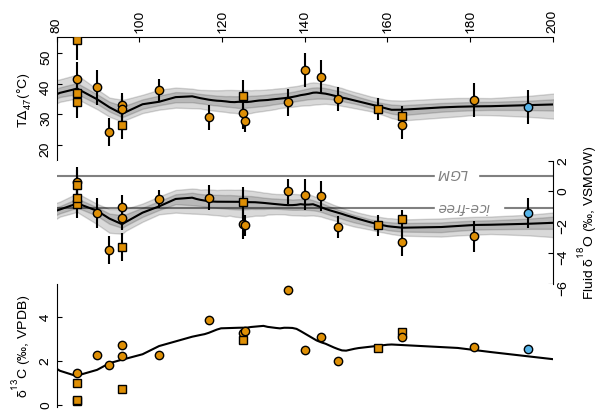

In [38]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle


fig, axes = plt.subplots(3, 1, sharex = True)


LOWESS_color = 'black'

# --- LOWESS AND ERROR ---
axes[0].plot(df_lowess_CI['Strat_height_C22-4'],
        smoothed_TD47_95, color = LOWESS_color, zorder = 4, label = 'D47')

axes[0].fill_between(df_lowess_CI['Strat_height_C22-4'],
        top_TD47_95, bottom_TD47_95, color = LOWESS_color, alpha = 0.15, zorder = 4)

axes[0].fill_between(df_lowess_CI['Strat_height_C22-4'],
        top_TD47_68, bottom_TD47_68, color = LOWESS_color, alpha = 0.15, zorder = 4)

axes[1].plot(df_lowess_CI['Strat_height_C22-4'],
        smoothed_d18w_95, color =LOWESS_color, zorder = 3)

axes[1].fill_between(df_lowess_CI['Strat_height_C22-4'],
        top_d18w_95, bottom_d18w_95, color = LOWESS_color, alpha = 0.15, zorder = 3)

axes[1].fill_between(df_lowess_CI['Strat_height_C22-4'],
        top_d18w_68, bottom_d18w_68, color = LOWESS_color, alpha = 0.15, zorder = 3)

axes[2].plot(df_lowess_CI['Strat_height_C22-4'],
    smoothed_d13C_95, color = LOWESS_color, zorder = 3)




# --- DATA POINTS ---

for ind, _row in df_lowess_CI_sam.iterrows():
    
    marker = 'o'
    color = pal[1]
    ms = 6
    
    if _row.Category == 'Dolomite':
        color = pal[3]
    elif _row.Category == 'Fossil':
        marker = 's'
    if (_row['Strat_height_C22-4'] > 190) and (_row['Strat_height_C22-4'] < 217):
        #marker = 'o'
        color = pal[9]
    elif _row['Strat_height_C22-4'] < 190:
        color = pal[1]
        #marker = 'o'
    else:
        #marker = 'o'
        color = pal[0]

    axes[0].errorbar(x = _row['Strat_height_C22-4'],
                y = _row.T_MIT,
                yerr = _row.T_MIT_SE_lower,
                c = color, 
                ecolor = 'black',
                mec = 'k',
                marker = marker,
                ls='none',
                ms = ms, zorder = 5)


    # eb1 = axes[0].errorbar(x = df_lowess_CI_sam['Strat_height_C22-4'],
    #             y = df_lowess_CI_sam.T_MIT,
    #             yerr = df_lowess_CI_sam.T_MIT_2SE_lower,
    #             fmt = 'none',
    #             ecolor = 'gray',
    #             ls='none',
    #             ms = 5, zorder = 4)

    # eb1[-1][0].set_linestyle((0, (2, 1)))

    # # plot reps
    #axes[0].scatter(df_lowess_CI['Strat_height_C22-4'], df_lowess_CI['T_MIT'], c = 'gray', s = 10, alpha = 0.3, linewidths = 0)

    # Add another polygon w 68% CI





    #axes[0].grid()


    # ------ FLUID d18O --------




    axes[1].errorbar(x = _row['Strat_height_C22-4'],
                y = _row.d18Ow_VSMOW,
                yerr = _row.d18Ow_VSMOW_1SE_lower,
                c = color, 
                ecolor = 'black',
                mec = 'k',
                marker = marker,
                ls='none',
                ms = ms, zorder = 5)


    # eb1 = axes[1].errorbar(x = df_lowess_CI_sam['Strat_height_C22-4'],
    #             y = df_lowess_CI_sam.d18Ow_VSMOW,
    #             yerr = df_lowess_CI_sam.d18Ow_VSMOW_2SE_lower,
    #             fmt = 'none', 
    #             ecolor = 'gray',
    #             ls='none',
    #             ms = 5, zorder = 4)

    # eb1[-1][0].set_linestyle((0, (2, 1)))
    
    axes[2].errorbar(x = _row['Strat_height_C22-4'],
                        y = _row.d13C_VPDB,
                        yerr = 0.01,
                        c = color, 
                        ecolor = 'gray',
                        mec = 'k',
                        marker = marker,
                        ls='none',
                        ms = ms, zorder = 5)


    #axes[2].scatter(df_lowess_CI['Strat_height_C22-4'], df_lowess_CI.d13C_VPDB, c = 'gray', s = 10, alpha = 0.3, linewidths = 0)






#axes[1].scatter(df_lowess_CI['Strat_height_C22-4'], df_lowess_CI.d18Ow_VSMOW, c = 'gray', s = 10, alpha = 0.3, linewidths = 0)

axes[1].axhline(-1.1, ls = '-', color = 'gray', zorder = 0)
axes[1].axhline(1, ls = '-', color = 'gray', zorder = 0)

afont = {'fontname':'Arial'}

axes[1].add_patch(Rectangle((171.5, 0.5), 10.5, 1, color = 'white'))
axes[1].add_patch(Rectangle((171.5, -1.5), 16.5, 1, color = 'white'))

axes[1].text(172, -1.3, '$\it{ice}$-$\it{free}$', **afont, color = 'gray', rotation = 180, zorder = 3)
axes[1].text(172, 1, '$\it{LGM}$', **afont, color = 'gray', rotation = 180, zorder = 3)


#axes[1].grid()

# ------- Mineral d18O ------- 


# axes[2].errorbar(x = df_lowess_CI_sam['Strat_height_C22-4'],
#             y = df_lowess_CI_sam.d18O_VPDB_mineral,
#             yerr = 0.01,
#             c = 'white', 
#             ecolor = 'black',
#             mec = 'k',
#             marker = 'o',
#             ls='none',
#             ms = 5, zorder = 5)

# ax2 = axes[2].twinx()

#     # -- d18O dynamic T --

# ax2.plot(df_lowess_CI['Strat_height_C22-4'],
#         smoothed_Td18O_dyn_95, color = pal[1], zorder = 3, label = 'dynamic d18Ow')

# ax2.fill_between(df_lowess_CI['Strat_height_C22-4'],
#         top_Td18O_dyn_95, bottom_Td18O_dyn_95, color = pal[1], alpha = 0.3, zorder = 3)

#     # -- d18O T ice free --

# ax2.plot(df_lowess_CI['Strat_height_C22-4'],
#         smoothed_Td18O_IF_95, color = pal[2], zorder = 3, label = 'ice free')

# ax2.fill_between(df_lowess_CI['Strat_height_C22-4'],
#         top_Td18O_IF_95, bottom_Td18O_IF_95, color = pal[2], alpha = 0.3, zorder = 3)


# ------- CARBON ---------


# axes[2].fill_between(df_lowess_CI['Strat_height_C22-4'],
#         top_d13C_95, bottom_d13C_95, color = 'black', alpha = 0.15, zorder = 3)



# axes[2].fill_between(df_lowess_CI['Strat_height_C22-4'],
#         top_d13C_68, bottom_d13C_68, color = 'black', alpha = 0.3, zorder = 3)


# ------- ZONES ---------
#axes[0].add_patch(Rectangle((160, 20), 30, 30))


# -------- PLOT FORMATTING ---------

axes[0].set_xlim(170, 315) # BW
axes[0].set_xlim(80, 200)# Pederson
axes[1].set_ylim(-6, 2) 
axes[0].set_ylim(15, 55)

    #axes[0].set_ylim(25, 55)

#axes[1].set_ylim(-2, 2)


#axes[0].legend(loc = 'lower right')

axes[0].set_ylabel(u'T$\Delta_{47}$($\degree$C)')
axes[1].set_ylabel(u'Fluid $\delta^{18}O$ (‰, VSMOW)')
#axes[2].set_ylabel(u'Mineral $\delta^{18}O$ (‰, VPDB)')
axes[2].set_ylabel(u'$\delta^{13}C$ (‰, VPDB)')

axes[0].spines[['bottom', 'right']].set_visible(False)
axes[0].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop = True, labelrotation = 90)
axes[0].tick_params(axis='y', labelrotation = 90)
axes[0].set_xlabel('Core depth (ft)', rotation = 180)

axes[0].yaxis.tick_left()

axes[1].spines[['top', 'bottom', 'left']].set_visible(False)
axes[1].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labelrotation = 90)
axes[1].yaxis.set_label_position('right')
axes[1].tick_params(axis='y', labelrotation = 90)
axes[1].yaxis.tick_right()

axes[2].spines[['top', 'right', 'bottom']].set_visible(False)
axes[2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False, labelrotation = 90)

axes[2].tick_params(axis='y', labelrotation = 90)
axes[2].yaxis.tick_left()





fig.subplots_adjust(hspace=0)

#plt.tight_layout()

#plt.savefig('T_d18Ow_horiz_pedersen.pdf', dpi = 300)

Pick ~8 samples to do ~10 reps of that go through excursion up to about 200. Focus on cold samples. Try just to plot well-repped.

In [18]:
print(smoothed_TD47_95)
#print(smoothed_Td18O_IF_95)
#smoothed_d18w_95


[30.47321245883404, 30.47321245883404, 30.47321245883404, 30.47321245883404, 30.47321245883404, 30.47321245883404, 35.952144326650625, 35.952144326650625, 35.952144326650625, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.179288489085934, 40.48636049520303, 40.48636049520303, 40.48636049520303, 38.520648806384315, 38.520648806384315, 38.520648806384315, 38.520648806384315, 38.520648806384315, 38.520648806384315, 38.520648806384315, 38.520648806384315, 38.520648806384315, 38.520648806384315, 38.520648806384315, 35.26644385079658, 35.26644385079658, 35.26644385079658, 34.36002018913217, 34.36002018913217, 34.36002018913217, 34.36002018913217, 34.36002018913217, 34.36002018913217, 33.267587721333996, 33.267587721333996, 33.267587721333996, 33.267587721333996, 33.267587721333996, 33.26758772133399

In [27]:
display(df_lowess_CI_sam.d18Ow_VSMOW)
display(df_lowess_CI_sam.Sample)

4    -3.9
10   -2.9
14   -0.3
13   -0.7
18    1.2
20    0.8
25   -1.8
26   -1.8
27   -0.5
29   -1.2
31    1.6
33    0.2
35   -1.1
37   -0.6
40   -0.9
39   -0.2
45   -1.8
46   -0.5
47    0.9
50   -1.0
52   -1.1
61   -1.0
Name: d18Ow_VSMOW, dtype: float64

4         BW-174
10        BW-188
14      BW-198-A
13        BW-198
18      BW-205-C
20        BW-210
25        BW-220
26        BW-222
27        BW-226
29        BW-234
31        BW-240
33      BW-241-B
35        BW-246
37        BW-250
40    BW-252.6-C
39    BW-252.6-B
45        BW-254
46        BW-262
47    BW-263_5-A
50        BW-270
52        BW-278
61        BW-310
Name: Sample, dtype: object

[0.63201264 0.63201264 0.63201264 0.63201264 0.63201264 0.63201264
 2.25229332 2.25229332 2.25229332 3.43476515 3.43476515 3.43476515
 3.43476515 3.43476515 3.43476515 3.43476515 3.43476515 3.43476515
 3.43476515 3.43476515 3.43476515 3.43476515 4.09195146 4.09195146
 4.09195146 4.43704912 4.43704912 4.43704912 4.43704912 4.43704912
 4.43704912 4.43704912 4.43704912 4.43704912 4.43704912 4.43704912
 5.08541506 5.08541506 5.08541506 5.17670058 5.17670058 5.17670058
 5.17670058 5.17670058 5.17670058 5.36592377 5.36592377 5.36592377
 5.36592377 5.36592377 5.36592377 5.3876277  5.3876277  5.3876277
 5.3876277  5.3876277  5.3876277  5.3876277  5.3876277  5.3876277
 5.3876277  5.33240886 5.33240886 5.33240886 5.30850067 5.30850067
 5.30850067 5.30850067 5.30850067 5.30850067 5.30850067 5.30850067
 5.30850067 5.30850067 5.22365968 5.22365968 5.22365968 5.22365968
 5.17846068 5.17846068 5.17846068 5.17846068 5.17846068 5.17846068
 5.17846068 5.17846068 5.17846068 5.17846068 5.00889221 5.008892

(170.0, 310.0)

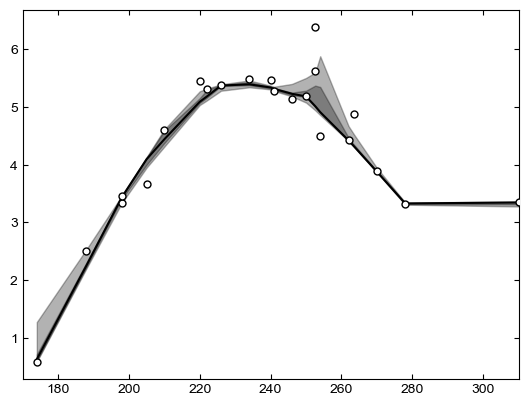

In [19]:
smoothed, bottom, top = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d13C_VPDB,
                df_lowess_CI['Strat_height_C22-4'],
                0.95)

print(smoothed)

plt.plot(df_lowess_CI['Strat_height_C22-4'],
        smoothed, color = 'black', zorder = 3)

plt.fill_between(df_lowess_CI['Strat_height_C22-4'],
        top, bottom, color = 'black', alpha = 0.3, zorder = 3)

plt.errorbar(x = df_lowess_CI_sam['Strat_height_C22-4'],
            y = df_lowess_CI_sam.d13C_VPDB,
            yerr = 0.01,
            c = 'white', 
            ecolor = 'gray',
            mec = 'k',
            marker = 'o',
            ls='none',
            ms = 5, zorder = 5)

smoothed, bottom, top = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d13C_VPDB,
                df_lowess_CI['Strat_height_C22-4'],
                0.68)

plt.fill_between(df_lowess_CI['Strat_height_C22-4'],
        top, bottom, color = 'black', alpha = 0.3, zorder = 3)

plt.xlim(170, 310)

(170.0, 310.0)

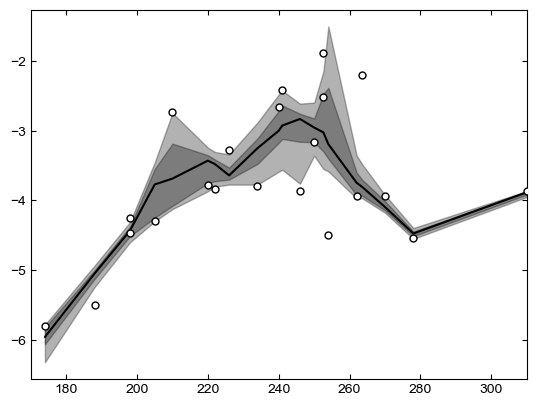

In [20]:
smoothed, bottom, top = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d18O_VPDB_mineral,
                df_lowess_CI['Strat_height_C22-4'],
                0.95)

plt.plot(df_lowess_CI['Strat_height_C22-4'],
        smoothed, color = 'black', zorder = 3)

plt.fill_between(df_lowess_CI['Strat_height_C22-4'],
        top, bottom, color = 'black', alpha = 0.3, zorder = 3)

plt.errorbar(x = df_lowess_CI_sam['Strat_height_C22-4'],
            y = df_lowess_CI_sam.d18O_VPDB_mineral,
            yerr = 0.01,
            c = 'white', 
            ecolor = 'gray',
            mec = 'k',
            marker = 'o',
            ls='none',
            ms = 5, zorder = 5)

smoothed, bottom, top = lowess_CI(df_lowess_CI['Strat_height_C22-4'], 
                df_lowess_CI.d18O_VPDB_mineral,
                df_lowess_CI['Strat_height_C22-4'],
                0.68)

plt.fill_between(df_lowess_CI['Strat_height_C22-4'],
        top, bottom, color = 'black', alpha = 0.3, zorder = 3)

plt.xlim(170, 310)

In [21]:
# from moepy import lowess, eda

In [22]:
# lowess_model = lowess.Lowess()

# y = df_reps[df_reps['Location'] == 'BW'].T_MIT.to_numpy()
# x = df_reps[df_reps['Location'] == 'BW']['Strat_height_C22-4'].to_numpy()

# lowess_model.fit(y, x)

# df_bootstrap = lowess.bootstrap_model(
#     y, 
#     x, 
#     num_runs=1000, 
#     model=lowess.Lowess(), 
#     frac=0.2, 
#     num_fits=20
# )


# x_pred = np.linspace(0, 50, 500)
# y_pred = lowess_model.predict(x_pred)

# df_conf_intvl = lowess.get_confidence_interval(df_bootstrap, conf_pct=0.95)

# # Plotting
# fig, ax = plt.subplots(dpi=150)

# ax.plot(y_pred, x_pred, 'k--', label='Original', linewidth=1, zorder=2)
# ax.fill_between(df_conf_intvl.index, df_conf_intvl['min'], df_conf_intvl['max'], color='r', edgecolor='k', alpha=0.25, label='95% Confidence')
# ax.scatter(y, x, label='With Noise', color='w', edgecolor='k', linewidth=0.3, s=2.5, zorder=1)




In [23]:
# # copied from https://james-brennan.github.io/posts/lowess_conf/

# # Try reps vs. no reps but fancy bootstrap
# # Change d18Ow to d18Ow_KON_97

# frac = 0.4

# import scipy
# from statsmodels.nonparametric.smoothers_lowess import lowess
# from scipy.interpolate import BSpline, make_interp_spline, interp1d

# def smooth(x, y, xgrid):
#     samples = np.random.choice(len(x), 50, replace=True)
#     y_s = y[samples]
#     x_s = x[samples]
#     y_sm = lowess(y_s,x_s, frac=frac, it=5,
#                      return_sorted = False)
#     # regularly sample it onto the grid
#     y_grid = interp1d(x_s, y_sm, 
#                                         fill_value='extrapolate')(xgrid)
#     return y_grid

# df_reps_lowess = df_reps[(df_reps['Location'] == 'BW') & (df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Vein') & (df_reps['Category'] != 'Cement')]



# d18Ow_lowess = lowess(df_reps_lowess['d18Ow_VSMOW_KON97'], 
#                       df_reps_lowess['Strat_height_C22-4'])

# # Calculate and plot T from d18O_mineral using interpolation of LOWESS-smoothed d18Ow data.
# df_d18Ow = pd.DataFrame()
# df_d18Ow['strat'] = d18Ow_lowess.T[0] #
# df_d18Ow['d18Ow'] = d18Ow_lowess.T[1]
# f_linear = interp1d(df_d18Ow['strat'], df_d18Ow['d18Ow'], bounds_error=False, kind='linear', fill_value='extrapolate')
# interp_ht = df_reps[(df_reps['Location'] == 'BW') & (df_reps['Mineralogy'] == 'Calcite') & (df_reps['Category'] != 'Vein') & (df_reps['Category'] != 'Cement')]['Strat_height_C22-4']
# interp_d18Ow = f_linear(interp_ht)

# T_d18O_dynamic = []
# d18O_T_KON97_icefree = []

# for i in range(len(df_reps_lowess)):#[
#     T_d18O_dynamic.append(calc_d18O_T_KON97(df_reps_lowess['d18O_VPDB_mineral'].iloc[i], interp_d18Ow[i]))
#     d18O_T_KON97_icefree.append(calc_d18O_T_KON97(df_reps_lowess['d18O_VPDB_mineral'].iloc[i], -1.1))


# df_reps_lowess['T_d18O_dynamic'] = T_d18O_dynamic
# df_reps_lowess['d18O_T_KON97_icefree'] = d18O_T_KON97_icefree

# x = df_reps_lowess['Strat_height_C22-4'].to_numpy()

# y_D47 = df_reps_lowess['T_MIT'].to_numpy()
# y_dyn = df_reps_lowess['T_d18O_dynamic'].to_numpy()
# y_IF = df_reps_lowess['d18O_T_KON97_icefree'].to_numpy()


# xgrid = np.linspace(x.min(),x.max())
# K = 100


# smooths_D47 = np.stack([smooth(x, y_D47, xgrid) for k in range(K)]).T
# smooths_dyn = np.stack([smooth(x, y_dyn, xgrid) for k in range(K)]).T
# smooths_IF = np.stack([smooth(x, y_IF, xgrid) for k in range(K)]).T

# stderr_D47 = np.nanstd(smooths_D47, axis=1, ddof=0)
# mean_D47 = np.nanmean(smooths_D47, axis=1)

# stderr_dyn = np.nanstd(smooths_dyn, axis=1, ddof=0)
# mean_dyn = np.nanmean(smooths_dyn, axis=1)

# stderr_IF = np.nanstd(smooths_IF, axis=1, ddof=0)
# mean_IF = np.nanmean(smooths_IF, axis=1)

# # c25 = np.nanpercentile(smooths, 2.5, axis=1) #2.5 percent
# # c97 = np.nanpercentile(smooths, 97.5, axis=1) # 97.5 percent
# # a 95% confidence interval

# n_SE = 1

# plt.fill_between(xgrid, mean_D47-n_SE*stderr_D47,
#                      mean_D47+n_SE*stderr_D47, alpha=0.25, color = pal[2])

# plt.fill_between(xgrid, mean_dyn-n_SE*stderr_dyn,
#                      mean_dyn+n_SE*stderr_dyn, alpha=0.25,  color = pal[0])

# plt.fill_between(xgrid, mean_IF-n_SE*stderr_IF,
#                      mean_IF+n_SE*stderr_IF, alpha=0.25,  color = pal[1])

# plt.plot(xgrid, mean_D47, color=pal[2], label = 'D47')
# plt.plot(xgrid, mean_IF, color=pal[1], label = 'IF')
# plt.plot(xgrid, mean_dyn, color=pal[0], label = 'VAR.')
# plt.xlim(310, 175)
# plt.ylim(20, 45)
# plt.legend()

